## New York City Airbnb Dimensionality Reduction using PCA
When working with a dataset with many features it is extremely difficult to visualize/explore the relationships between features. Not only it makes the EDA process difficult but also affects the machine learning model’s performance since the chances are that you might overfit your model or violate some of the assumptions of the algorithm, like the independence of features in linear regression. This is where dimensionality reduction comes in.

In machine learning, dimensionality reduction is the process of reducing the number of random variables under consideration by obtaining a set of principal variables. By reducing the dimension of your feature space, you have fewer relationships between features to consider which can be explored and visualized easily and also you are less likely to overfit your model. One way to perform Dimensionality reduction is by using Principal Components Analysis.

Principal Component Analysis or PCA is a linear feature extraction technique. It performs a linear mapping of the data to a lower-dimensional space in such a way that the variance of the data in the low-dimensional representation is maximized. It does so by calculating the eigenvectors from the covariance matrix. The eigenvectors that correspond to the largest eigenvalues (the principal components) are used to reconstruct a significant fraction of the variance of the original data. For more details read my post on PCA here: [Intro-to-pca](https://shravan-kuchkula.github.io/PCA-in-R/)

In simpler terms, PCA combines your input features in a specific way that you can drop the least important feature while still retaining the most valuable parts of all of the features. As an added benefit, each of the new features or components created after PCA are all independent of one another.

## Get the data

In [1]:
# data managing and display libs
import pandas as pd
import numpy as np
import os
import io

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline 

# sagemaker libraries
import boto3

In [2]:
# boto3 client to get S3 data
s3_client = boto3.client('s3')
bucket_name='skuchkula-sagemaker-airbnb'

In [3]:
# list the bucket objects
response = s3_client.list_objects(Bucket=bucket_name)

# get list of objects inside the bucket
files = [file['Key'] for file in response['Contents']]
files

['clean/airbnb_clean.csv',
 'detailed_listings.csv',
 'feature_eng/amenities_features.csv',
 'feature_eng/description_features.csv',
 'feature_eng/host_verification_features.csv',
 'feature_eng/merged_features.csv',
 'feature_eng/min_max_scaled_final_df.csv',
 'feature_eng/scaled_final_df.csv',
 'summary_listings.csv']

In [4]:
# download the file from s3
def get_data_frame(bucket_name, file_name):
    '''
    Takes the location of the dataset on S3 and returns a dataframe.
    arguments:
            bucket_name: the name of the bucket
            file_name: the key inside the bucket
    returns:
            dataframe
    '''
    # get an S3 object by passing in the bucket and file name
    data_object = s3_client.get_object(Bucket=bucket_name, Key=file_name)
    
    # information is in the "Body" of the object
    data_body = data_object["Body"].read()
    
    # read in bytes data
    data_stream = io.BytesIO(data_body)
    
    # create a dataframe
    df = pd.read_csv(data_stream, header=0, delimiter=",", low_memory=False, keep_default_na=False)
    
    return df

In [7]:
airbnb_file='feature_eng/min_max_scaled_final_df.csv'
df_airbnb = get_data_frame(bucket_name, airbnb_file)
df_airbnb.head()

,accommodates,bathrooms,bedrooms,beds,guests_included,extra_people,availability_30,availability_60,availability_90,number_of_reviews,...,description_contains_yankee,description_contains_yard,description_contains_year,description_contains_yellow,description_contains_yoga,description_contains_york,description_contains_young,description_contains_yummy,description_contains_zero,description_contains_zone
0,0.04,0.064516,0.000000,0.025,0.066667,0.000000,0.433333,0.283333,0.344444,0.071987,...,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
1,0.04,0.064516,0.071429,0.025,0.066667,0.066667,1.000000,1.000000,1.000000,0.000000,...,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
2,0.00,0.064516,0.071429,0.025,0.000000,0.066667,0.000000,0.000000,0.000000,0.014085,...,0.0,0.0,0.00000,0.0,0.137645,0.000000,0.0,0.0,0.0,0.0
3,0.04,0.064516,0.071429,0.025,0.066667,0.333333,0.800000,0.550000,0.700000,0.117371,...,0.0,0.0,0.00000,0.0,0.000000,0.074083,0.0,0.0,0.0,0.0
4,0.04,0.064516,0.071429,0.025,0.000000,0.100000,0.000000,0.000000,0.000000,0.076682,...,0.0,0.0,0.18384,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0


## PCA analysis
PCA attempts to reduce the number of features within a dataset while retaining the “principal components”, which are defined as weighted, linear combinations of existing features that are designed to be linearly independent and account for the largest possible variability in the data! You can think of this method as taking many features and combining similar or redundant features together to form a new, smaller feature set.

Using sklearn's PCA implementation, we pass in n_components=50 to produce 50 principal components.

n_components: An integer that defines the number of PCA components to produce. 

In [10]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
pca.fit(df_airbnb)

PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

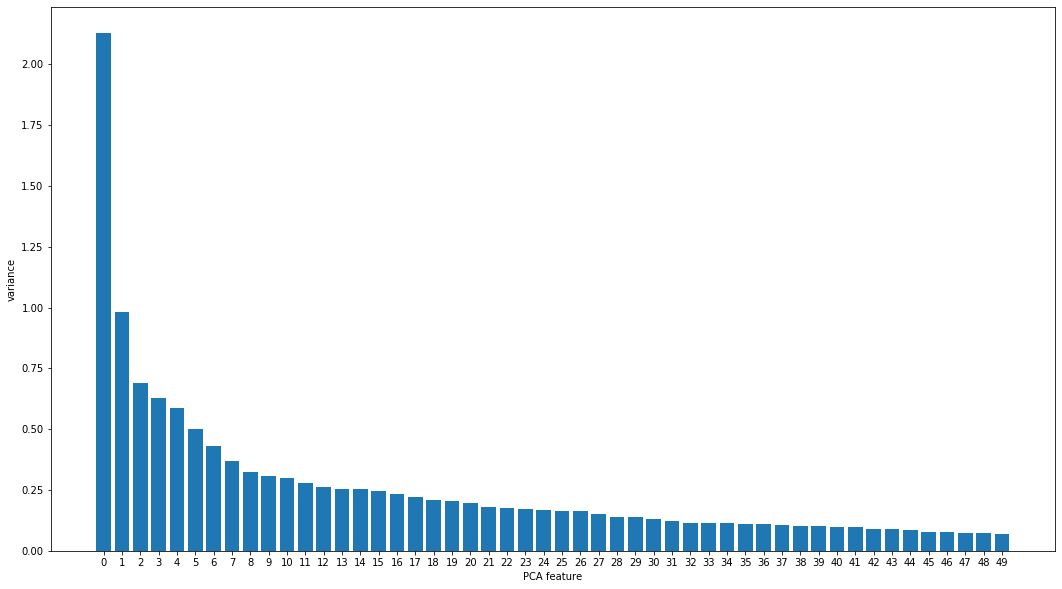

In [52]:
features = range(pca.n_components_)
plt.figure(figsize=(18,10))
plt.bar(features, pca.explained_variance_)
plt.xticks(features)
plt.ylabel('variance')
plt.xlabel('PCA feature')
plt.show()

The breakdown of how much variance explained by each PCA feature is shown in the above plot.

In [14]:
pca_features = pca.transform(df_airbnb)
pca_features.shape

(45605, 50)

In [17]:
pca_df = pd.DataFrame(pca_features)
pca_df.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,2.658552,-1.455526,0.699093,-0.553412,-0.125384,-0.654187,-0.044713,-0.001357,0.108582,1.333186,...,0.576904,0.466956,0.331311,0.261779,-0.330193,1.620287,0.867739,-0.798060,-0.576860,-0.254925
1,-1.644174,-0.715321,1.097099,0.893833,0.399013,-0.139751,-1.183842,-1.132572,0.996817,0.151908,...,-0.252328,0.226731,0.269839,-0.211928,0.147831,1.354929,0.801862,-0.292820,-0.804985,-0.202175
2,-1.012114,-1.718006,-0.320889,-0.356113,0.113797,0.392780,-0.399569,-0.819086,-0.133456,-0.200684,...,0.193168,0.068044,0.015844,0.197295,-0.167786,1.117572,0.749340,0.109282,-0.870940,-0.278948
3,0.067402,-0.520919,-0.263865,0.353879,-0.907122,-0.906052,-1.158888,-0.624668,-0.071571,0.780228,...,0.416250,-0.057388,0.073780,0.143102,0.198163,1.440193,0.641507,-0.021390,-0.912154,-0.285108
4,-1.666907,1.296202,0.520533,0.659033,1.262238,-0.516450,-0.827510,-0.678685,0.010626,0.180606,...,-0.214280,-0.095810,0.224063,0.083689,-0.192449,0.410582,0.017357,0.246550,0.796558,0.307420


## Create price_category to aid in visualization
As of now, the price feature is a continuous variable. We can apply binning to create a discreatized version of the price column. Doing so, we can filter locations based on price category. Ideally, this should be inside the Feature Engineering step, but for now, we will go with it.

In [19]:
# Read in the cleaned dataset
airbnb_detailed = pd.read_csv('airbnb_clean.csv')

# calculate the adjusted_price
airbnb_detailed['adjusted_price'] = airbnb_detailed.price / airbnb_detailed.minimum_nights

In [24]:
# let pandas know that you are working with a copy
airbnb_temp = airbnb_detailed.copy()

# get the indices of low, med and high rows
low_indexes = airbnb_temp[airbnb_temp.adjusted_price < 50].index
med_indexes = airbnb_temp[(airbnb_temp.adjusted_price >= 50) &
                         (airbnb_temp.adjusted_price < 200)].index
high_indexes = airbnb_temp[(airbnb_temp.adjusted_price >= 200)].index

In [26]:
# create a new column called 'price_category'
airbnb_temp.loc[low_indexes, 'price_category'] = 'low'
airbnb_temp.loc[med_indexes, 'price_category'] = 'medium'
airbnb_temp.loc[high_indexes, 'price_category'] = 'high'
airbnb_temp.head()

,id,name,summary,description,host_listings_count,host_total_listings_count,host_verifications,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,...,cancellation_policy_strict,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60,require_guest_profile_picture_f,require_guest_profile_picture_t,require_guest_phone_verification_f,require_guest_phone_verification_t,adjusted_price,price_category
0,2595,Skylit Midtown Castle,"Find your romantic getaway to this beautiful, ...","Find your romantic getaway to this beautiful, ...",5.0,5.0,"['email', 'phone', 'reviews', 'kba', 'work_ema...",Midtown,Manhattan,40.75362,...,0,1,0,0,0,1,0,1,225.000000,high
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,NaN,WELCOME TO OUR INTERNATIONAL URBAN COMMUNITY T...,1.0,1.0,"['email', 'phone', 'google', 'reviews', 'jumio...",Harlem,Manhattan,40.80902,...,0,1,0,0,0,1,0,1,50.000000,medium
2,5022,Entire Apt: Spacious Studio/Loft by central park,NaN,Loft apartment with high ceiling and wood floo...,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",East Harlem,Manhattan,40.79851,...,0,1,0,0,0,1,0,1,8.000000,low
3,5099,Large Cozy 1 BR Apartment In Midtown East,My large 1 bedroom apartment is true New York ...,My large 1 bedroom apartment is true New York ...,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",Murray Hill,Manhattan,40.74767,...,0,1,0,0,0,1,0,1,66.666667,medium
4,5121,BlissArtsSpace!,NaN,HELLO EVERYONE AND THANKS FOR VISITING BLISS A...,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'off...",Bedford-Stuyvesant,Brooklyn,40.68688,...,0,1,0,0,1,0,1,0,1.333333,low


In [27]:
airbnb_temp.price_category.value_counts()

low       25133
medium    18484
high       1988
Name: price_category, dtype: int64

## Merge PCA features with the original dataset

In [40]:
# take only cols that you want to display in visualization from main dataset
cols = ['price_category', 'name', 'id', 'price', 'adjusted_price', 
        'minimum_nights', 'bedrooms', 'bathrooms',
        'neighbourhood_group_cleansed', 'neighbourhood_cleansed']

airbnb_reduced = airbnb_temp[cols]

# merge this with PCA features
airbnb_final = pd.concat([airbnb_reduced, pca_df], axis=1)

airbnb_final.head()

,price_category,name,id,price,adjusted_price,minimum_nights,bedrooms,bathrooms,neighbourhood_group_cleansed,neighbourhood_cleansed,...,40,41,42,43,44,45,46,47,48,49
0,high,Skylit Midtown Castle,2595,225.0,225.000000,1,0.0,1.0,Manhattan,Midtown,...,0.576904,0.466956,0.331311,0.261779,-0.330193,1.620287,0.867739,-0.798060,-0.576860,-0.254925
1,medium,THE VILLAGE OF HARLEM....NEW YORK !,3647,150.0,50.000000,3,1.0,1.0,Manhattan,Harlem,...,-0.252328,0.226731,0.269839,-0.211928,0.147831,1.354929,0.801862,-0.292820,-0.804985,-0.202175
2,low,Entire Apt: Spacious Studio/Loft by central park,5022,80.0,8.000000,10,1.0,1.0,Manhattan,East Harlem,...,0.193168,0.068044,0.015844,0.197295,-0.167786,1.117572,0.749340,0.109282,-0.870940,-0.278948
3,medium,Large Cozy 1 BR Apartment In Midtown East,5099,200.0,66.666667,3,1.0,1.0,Manhattan,Murray Hill,...,0.416250,-0.057388,0.073780,0.143102,0.198163,1.440193,0.641507,-0.021390,-0.912154,-0.285108
4,low,BlissArtsSpace!,5121,60.0,1.333333,45,1.0,1.0,Brooklyn,Bedford-Stuyvesant,...,-0.214280,-0.095810,0.224063,0.083689,-0.192449,0.410582,0.017357,0.246550,0.796558,0.307420


## Save and upload to S3

In [41]:
airbnb_final.to_csv('airbnb_final.csv', index=False)

In [45]:
import configparser
config = configparser.ConfigParser()
config.read_file(open('credentials.cfg'))

KEY = config.get('AWS','KEY')
SECRET = config.get('AWS','SECRET')

In [46]:
import boto3

# Generate the boto3 client for interacting with S3
s3 = boto3.client('s3', region_name='us-east-1', 
                        # Set up AWS credentials 
                        aws_access_key_id=KEY, 
                        aws_secret_access_key=SECRET)

In [47]:
s3.upload_file(Bucket='skuchkula-sagemaker-airbnb',
              Filename='airbnb_final.csv',
              Key='feature/airbnb_final.csv')